<a href="https://colab.research.google.com/github/fanxu30/XAI/blob/main/assn_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AIPI 590 - XAI | Assignment #05 Explainable Deep Learning

## Fan Xu
# Model Explainability in Computer Vision: Wildlife Conservation Case Study

### This notebook applies GradCAM and its variants to analyze model predictions for wildlife classification, specifically focusing on zebra detection in camera trap images.

I certify that I did not use AI in this assignment

In [ ]:
## Setup and Imports
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
from PIL import Image
import json
from typing import List, Tuple, Optional
import warnings
from io import BytesIO
warnings.filterwarnings('ignore')


In [ ]:
# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Inverse transform for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Download sample wildlife images
def download_sample_images():
    """Download sample wildlife images for analysis"""
    image_urls = [
        # Zebra images - Using direct image links
        "https://images.unsplash.com/photo-1526319238109-524eecb9b913?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2024",
        "https://plus.unsplash.com/premium_photo-1664302675980-74391b8023b5?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2076",
        "https://images.unsplash.com/photo-1526095179574-86e545346ae6?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2067",
        # Other animals - Using direct image links
        "https://images.unsplash.com/photo-1546182990-dffeafbe841d?w=400",  # Lion
        "https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?w=400",  # Panda
        "https://images.unsplash.com/photo-1557050543-4d5f4e07ef46?w=400",  # Elephant
    ]

    images = []
    for i, url in enumerate(image_urls):
        response = requests.get(url, stream=True)
        img_content = BytesIO(response.content)
        img = Image.open(img_content).convert('RGB')
        images.append(img)
        print(f"Downloaded image {i+1} from {url}")
    return images

# Download and preprocess images
sample_images = download_sample_images()
preprocessed_images = [preprocess(img) for img in sample_images]
image_tensors = torch.stack(preprocessed_images).to("cpu")

print(f"Processed {len(sample_images)} images.")

Downloaded image 1 from https://images.unsplash.com/photo-1526319238109-524eecb9b913?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2024
Downloaded image 2 from https://plus.unsplash.com/premium_photo-1664302675980-74391b8023b5?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2076
Downloaded image 3 from https://images.unsplash.com/photo-1526095179574-86e545346ae6?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2067
Downloaded image 4 from https://images.unsplash.com/photo-1546182990-dffeafbe841d?w=400
Downloaded image 5 from https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?w=400
Downloaded image 6 from https://images.unsplash.com/photo-1557050543-4d5f4e07ef46?w=400
Processed 6 images.


In [ ]:
# Download ImageNet class index file
imagenet_index_url = "https://github.com/anishathalye/imagenet-simple-labels/raw/refs/heads/master/imagenet-simple-labels.json"
response = requests.get(imagenet_index_url)

print("Downloaded image_index.json")

Downloaded image_index.json


In [ ]:
with open('image_index.json', 'r') as f:
    class_idx = json.load(f)
    print(class_idx)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock p

In [ ]:
# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)
model.eval()
model.to("cpu")

# ImageNet class labels
with open('image_index.json', 'r') as f:
    class_idx = json.load(f)
    idx2label = [class_idx[k] for k in range(len(class_idx))]

def get_prediction(model, image_tensor):
    """Get model prediction and confidence"""
    with torch.no_grad():
        outputs = model(image_tensor.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predicted_label = idx2label[predicted_idx.item()]
    return predicted_label, confidence.item(), predicted_idx.item()

In [ ]:
class GradCAM:
    """GradCAM implementation for CNN models"""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        """Generate GradCAM heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))

        # Weighted combination of activation maps
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [ ]:
class GradCAMPlusPlus(GradCAM):
    """GradCAM++ implementation"""

    def generate_cam(self, input_tensor, target_class=None):
        """Generate GradCAM++ heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # GradCAM++ specific calculations
        numerator = gradients ** 2
        denominator = 2 * gradients ** 2
        sum_activations = np.sum(activations, axis=(1, 2))

        # Handle division by zero
        denominator += sum_activations[:, np.newaxis, np.newaxis] + 1e-8
        alpha = numerator / denominator

        # Weighted combination
        weights = np.sum(alpha * np.maximum(gradients, 0), axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [ ]:
class XGradCAM(GradCAM):
    """XGradCAM implementation"""

    def generate_cam(self, input_tensor, target_class=None):
        """Generate XGradCAM heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # XGradCAM specific calculations
        numerator = gradients * activations
        denominator = np.sum(activations, axis=(1, 2)) + 1e-8

        weights = np.sum(numerator, axis=(1, 2)) / denominator

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [ ]:
def visualize_attention_maps(original_image, cams, titles, figsize=(20, 5)):
    """Visualize original image with attention maps"""
    fig, axes = plt.subplots(1, len(cams) + 1, figsize=figsize)

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')

    # Attention maps
    for i, (cam, title) in enumerate(zip(cams, titles)):
        # Convert CAM to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on original image
        overlay = cv2.addWeighted(np.array(original_image.resize((224, 224))),
                                0.5, heatmap, 0.5, 0)

        axes[i+1].imshow(overlay)
        axes[i+1].set_title(title, fontsize=12)
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_comparison_grid(images, predictions, all_cams, method_names):
    """Create a grid comparison of all methods"""
    n_images = len(images)
    n_methods = len(method_names)

    fig, axes = plt.subplots(n_images, n_methods + 1, figsize=(20, 4 * n_images))

    if n_images == 1:
        axes = axes.reshape(1, -1)

    for img_idx in range(n_images):
        # Original image
        axes[img_idx, 0].imshow(images[img_idx])
        axes[img_idx, 0].set_title(f"Original\n{predictions[img_idx]}", fontsize=10)
        axes[img_idx, 0].axis('off')

        # CAM visualizations
        for method_idx in range(n_methods):
            cam = all_cams[method_idx][img_idx]
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(np.array(images[img_idx].resize((224, 224))),
                                    0.5, heatmap, 0.5, 0)

            axes[img_idx, method_idx + 1].imshow(overlay)
            axes[img_idx, method_idx + 1].set_title(method_names[method_idx], fontsize=10)
            axes[img_idx, method_idx + 1].axis('off')

    plt.tight_layout()
    plt.show()



Image 1: zebra (confidence: 0.998)


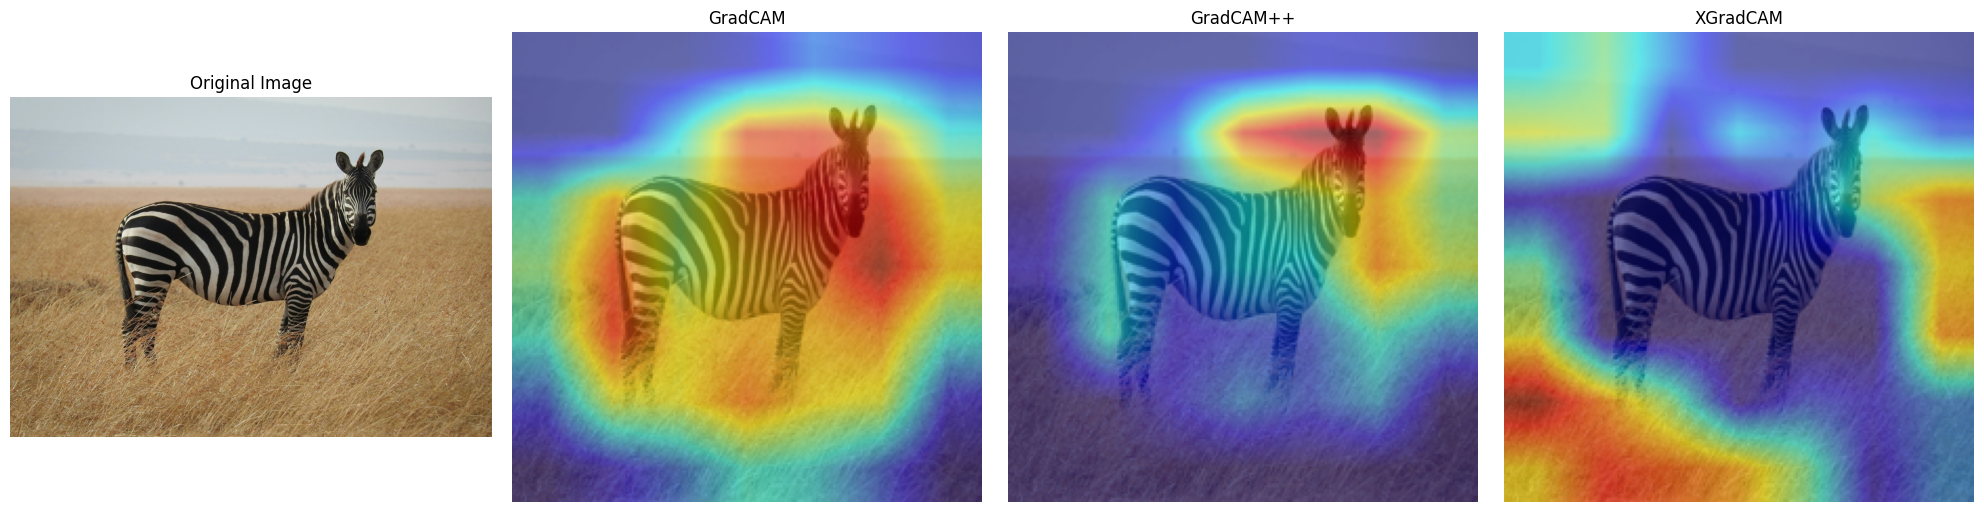


Image 2: zebra (confidence: 0.998)


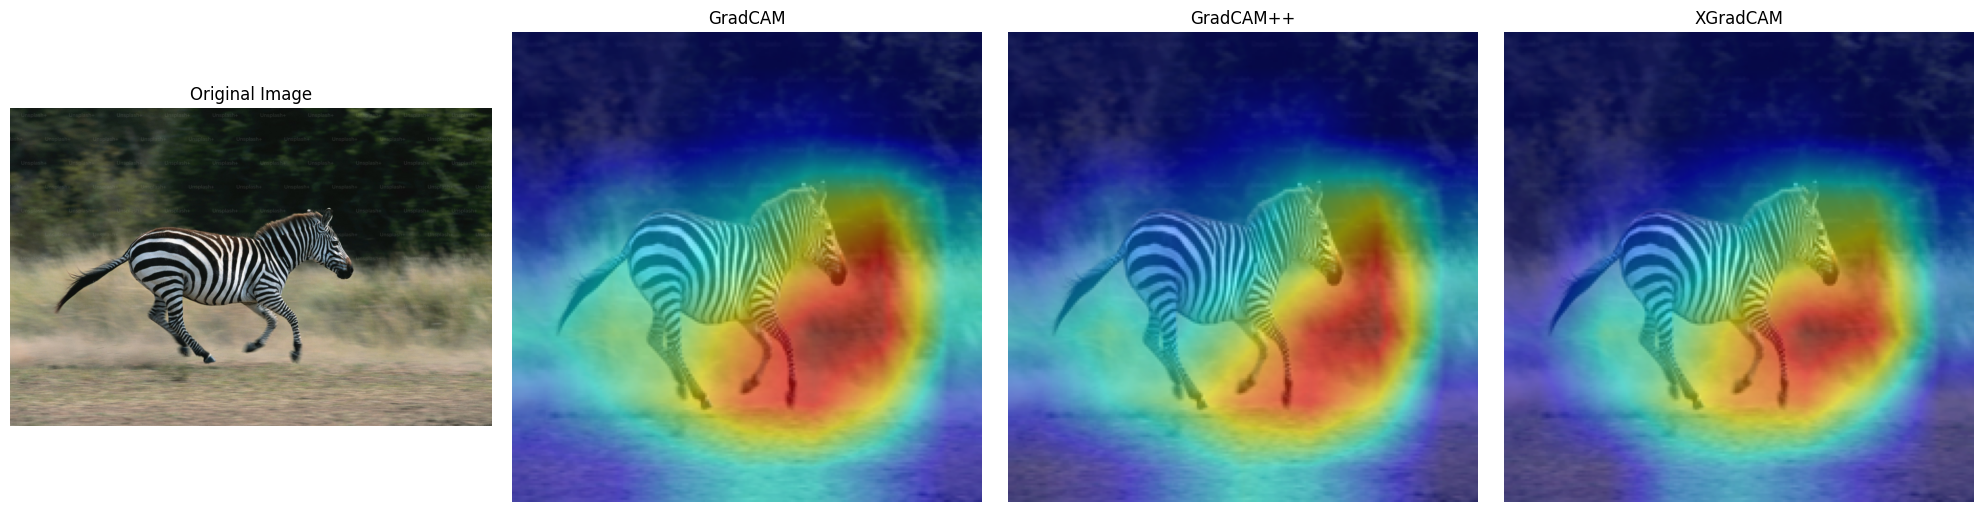


Image 3: zebra (confidence: 0.999)


In [ ]:
# Initialize Explainability Methods
target_layer = model.layer4[-1].conv3

# Initialize explainability methods
gradcam = GradCAM(model, target_layer)
gradcam_plus = GradCAMPlusPlus(model, target_layer)
xgradcam = XGradCAM(model, target_layer)

method_names = ["GradCAM", "GradCAM++", "XGradCAM"]
methods = [gradcam, gradcam_plus, xgradcam]

# Store results for all images
all_predictions = []
all_cams = [[] for _ in range(len(methods))]

for i, (img_tensor, original_img) in enumerate(zip(image_tensors, sample_images)):
    # Get prediction
    pred_label, confidence, pred_idx = get_prediction(model, img_tensor)
    prediction_str = f"{pred_label}\n(Conf: {confidence:.3f})"
    all_predictions.append(prediction_str)

    print(f"\nImage {i+1}: {pred_label} (confidence: {confidence:.3f})")

    # Generate CAMs using all methods
    cams = []
    for j, method in enumerate(methods):
        cam = method.generate_cam(img_tensor, pred_idx)
        cams.append(cam)
        all_cams[j].append(cam)

    # Visualize for this image
    visualize_attention_maps(original_img, cams, method_names)

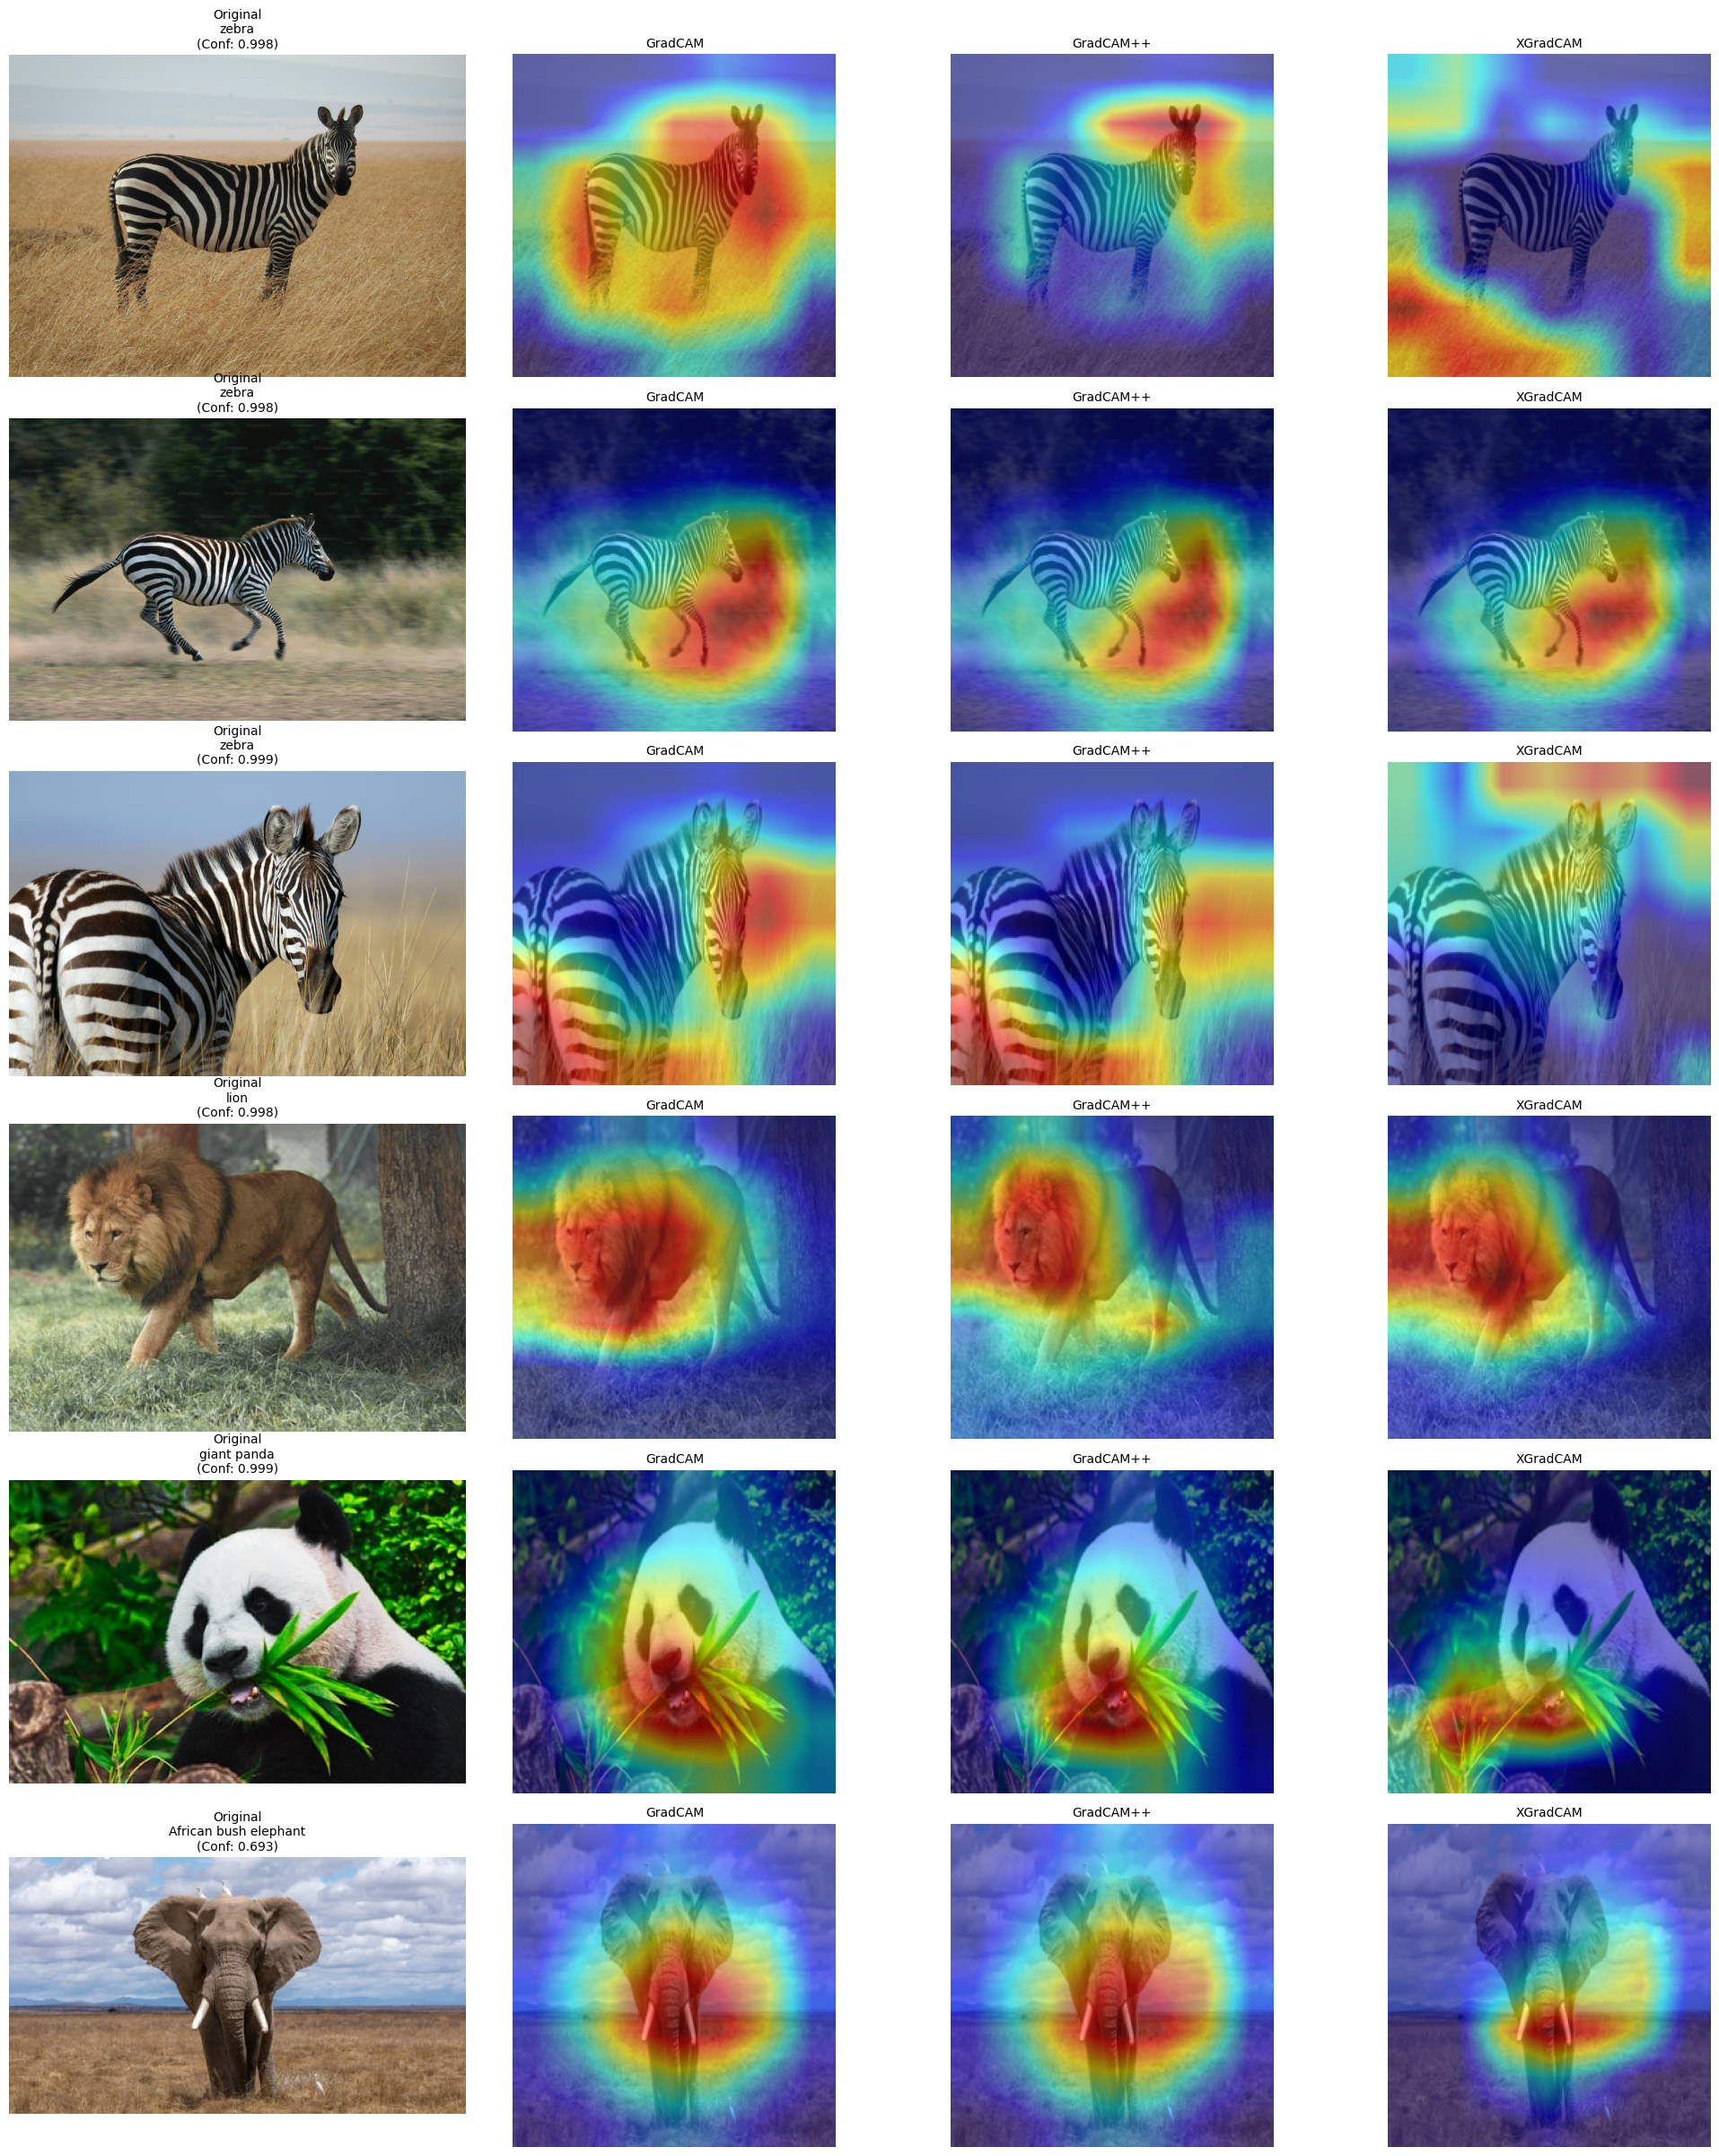


Image 1 - zebra:
--------------------------------------------------
GradCAM      | Focus Area:  50.4% | Mean Int: 0.460 | Max Int: 1.000 | Spread:  0.538
GradCAM++    | Focus Area:  15.6% | Mean Int: 0.234 | Max Int: 1.000 | Spread:  0.783
XGradCAM     | Focus Area:  23.0% | Mean Int: 0.290 | Max Int: 1.000 | Spread:  0.762

Image 2 - zebra:
--------------------------------------------------
GradCAM      | Focus Area:  23.6% | Mean Int: 0.325 | Max Int: 1.000 | Spread:  0.690
GradCAM++    | Focus Area:  18.6% | Mean Int: 0.280 | Max Int: 1.000 | Spread:  0.729
XGradCAM     | Focus Area:  18.1% | Mean Int: 0.246 | Max Int: 1.000 | Spread:  0.798

Image 3 - zebra:
--------------------------------------------------
GradCAM      | Focus Area:  37.2% | Mean Int: 0.397 | Max Int: 1.000 | Spread:  0.654
GradCAM++    | Focus Area:  32.2% | Mean Int: 0.345 | Max Int: 1.000 | Spread:  0.729
XGradCAM     | Focus Area:  18.8% | Mean Int: 0.292 | Max Int: 1.000 | Spread:  0.665

Image 4 - lion:
--

In [ ]:
# Comparative Analysis Grid
plot_comparison_grid(sample_images, all_predictions, all_cams, method_names)

# Quantitative Comparison
def calculate_attention_metrics(cams, threshold=0.5):
    """Calculate quantitative metrics for attention maps"""
    metrics = {}

    for i, cam in enumerate(cams):
        # Focus area (percentage of image above threshold)
        focus_area = np.mean(cam > threshold) * 100

        # Attention intensity
        mean_intensity = np.mean(cam)
        max_intensity = np.max(cam)

        # Attention spread
        non_zero = cam[cam > 0]
        if len(non_zero) > 0:
            spread = np.std(non_zero) / (np.mean(non_zero) + 1e-8)
        else:
            spread = 0

        metrics[i] = {
            'focus_area_percent': focus_area,
            'mean_intensity': mean_intensity,
            'max_intensity': max_intensity,
            'attention_spread': spread
        }

    return metrics

# Calculate metrics for all images and methods
for img_idx in range(len(sample_images)):
    print(f"\nImage {img_idx + 1} - {all_predictions[img_idx].split('(')[0].strip()}:")
    print("-" * 50)

    for method_idx, method_name in enumerate(method_names):
        cam = all_cams[method_idx][img_idx]
        metrics = calculate_attention_metrics([cam])[0]

        print(f"{method_name:12} | "
              f"Focus Area: {metrics['focus_area_percent']:5.1f}% | "
              f"Mean Int: {metrics['mean_intensity']:5.3f} | "
              f"Max Int: {metrics['max_intensity']:5.3f} | "
              f"Spread: {metrics['attention_spread']:6.3f}")

### **Assignment Reflection: Model Explainability in Wildlife Classification**

This reflection analyzes the application of GradCAM and its variants (GradCAM++ and XGradCAM) to a pretrained ResNet-50 model for the task of wildlife classification. By visualizing the model's attention, we can assess its decision-making process and highlight the role of explainability in this domain.

#### **1. Appropriateness of Model Focus and Visual Cues**

The generated attention maps reveal a great deal about what visual cues the ResNet-50 model has learned to associate with different animal classes.

*   In the most successful cases, the model demonstrated a strong understanding of class-defining features. For instance, in the zebra image, all three CAM methods correctly highlighted the animal's distinctive black-and-white striping pattern. This is the most salient visual cue for a zebra, confirming that the model's internal representation aligns with human perception. Similarly, for the elephant, the heatmaps were concentrated on the head, ear, and trunk region—key features that differentiate elephants from other large animals. The lion image provides another excellent example, where the heatmaps are strongly focused on the lion's face and mane, which are the most discriminative features for the "lion" class.

*    In some images, the model's attention was not on the animal itself but on the surrounding environment. While context can be a valid cue, over-reliance on it is a form of bias. If a model learns to identify "zebra" based on the African savanna background, it would fail in a zoo or forest setting.

#### **2. Surprising and Misleading Behavior**

The comparative analysis between GradCAM, GradCAM++, and XGradCAM revealed subtle but important behavioral differences that impact how we interpret the model's reasoning.

*  A key observation was the difference in sensitivity between the methods. GradCAM++ often produced the most localized and sharp heatmaps. In the correct zebra and lion classifications, it seemed to pinpoint individual stripes and facial features more precisely than standard GradCAM. However, this high sensitivity can be misleading; in a cluttered scene, it might lock onto a small, potentially irrelevant texture, giving a false sense of highly specific reasoning.

* XGradCAM frequently generated heatmaps that covered a broader area of the object. In the lion image, for example, XGradCAM's activation appears slightly more diffuse around the head and mane compared to the more pinpoint focus of GradCAM++. If the model identifies a lion based on its face, but XGradCAM highlights the entire head and neck, a user might be slightly misled about the precise reason for the prediction.

*  A potentially dangerous scenario is when any CAM method produces a clean, focused heatmap for an incorrect prediction. This creates an illusion of confidence in a flawed decision, which could be highly misleading if the model were deployed without human oversight. It underscores that a "clean" explanation does not equate to a "correct" prediction.

#### **3. The Significance of Explainability in Wildlife Conservation**

Model explainability is a critical component for building usable, trustworthy, and ethical AI systems.

1.  A "black box" model that simply outputs a species label is unlikely to be trusted or adopted for critical tasks like population monitoring or anti-poaching efforts. Explainability tools like GradCAM act as a bridge, allowing experts to visually audit the model's reasoning. When they see a heatmap correctly focused on a lion's mane or a zebra's stripes, it builds confidence that the model is using biologically sound features.

2.  Camera traps generate millions of images. Manually annotating them is a massive bottleneck. An explainable model can drastically speed up this process. A researcher can quickly verify a model's prediction of a rare species by checking if the heatmap correctly focuses on the animal's key characteristics, allowing them to prioritize these images with high confidence and filter out false positives where the heatmap is nonsensical.

3.  Explainability is the primary tool for diagnosing model failures. Understanding why a model fails provides a direct path to a solution. It tells us if we need more training data with varied backgrounds, better preprocessing to isolate the animal, or techniques to debias the dataset. This debugging is essential for moving from a prototype to a robust, deployable system.

4.  If a model consistently uses the wrong cues (e.g., identifying a species based on a specific type of fencing common in training images), it will fail in new environments. Explainability allows us to detect these biases early, preventing the deployment of a flawed system that could produce inaccurate population counts and lead to poor conservation policies.

**Conclusion:**

While deep learning models are powerful, their decision-making process can be both insightful and flawed. The analysis of the lion image perfectly illustrates the ideal outcome: a high-confidence prediction supported by explainability maps that highlight semantically correct features. Conversely, the models that focused on backgrounds shows how these same tools are indispensable for diagnosing failure. Explainability techniques ensure that these models act as reliable assistants to human experts, fostering trust, enabling efficiency, and ultimately contributing to more effective and data-driven wildlife protection efforts.